In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from ipywidgets import interact
import numpy as np
import cv2 as cv

In [22]:
image = cv.imread('./cat.png')

table_width = 180
table_height = 230

height, width, _ = image.shape
aspect_ratio = width / height

# scale using width
new_width = int(table_width * (1 - table_width/width))
new_height = int(new_width/aspect_ratio)

print(f'Aspect ratio: {aspect_ratio}')
print(f'New dimensions: ({new_width}, {new_height})')

# scale image to size of table
image = cv.resize(image, (new_width, new_height), interpolation=cv.INTER_AREA)

Aspect ratio: 0.75
New dimensions: (169, 225)


In [23]:
@interact(min_threshold=100, max_threshold=200, aperture=(3,7,2))
def get_contours(min_threshold, max_threshold, aperture):
	# get edges using Canny edge detector
	global edges
	edges = cv.Canny(image, min_threshold, max_threshold, apertureSize=aperture)

	# display original image
	plt.rcParams["figure.figsize"]=15,15
	plt.subplot(121)
	# opencv stores image as bgr, need to convert back to display properly
	plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
	plt.title('Original Image') 
	plt.xticks([])
	plt.yticks([])

	# display detected edges
	plt.subplot(122)
	plt.imshow(edges, cmap='gray')
	plt.title('Edges') 
	plt.xticks([])
	plt.yticks([])

	plt.show()


interactive(children=(IntSlider(value=100, description='min_threshold', max=300, min=-100), IntSlider(value=20…

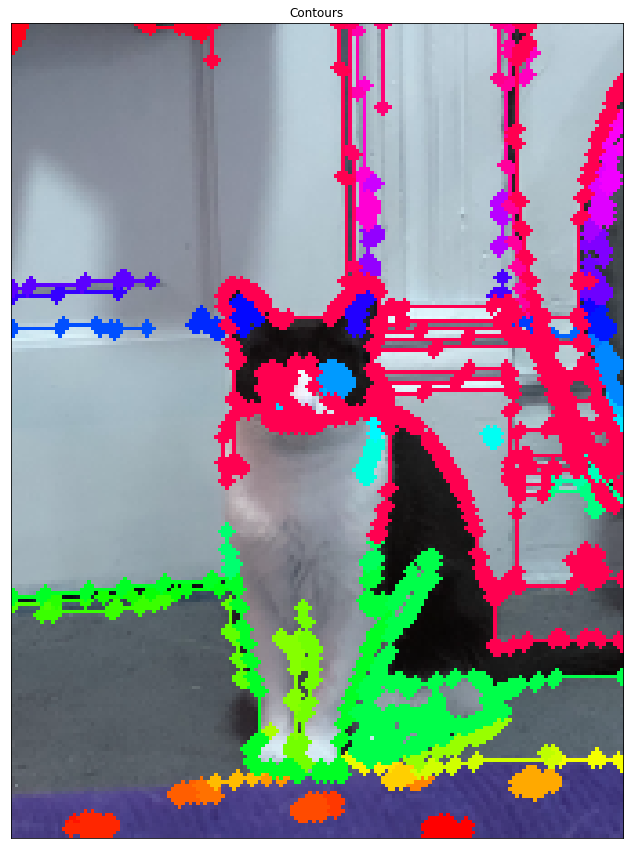

In [24]:
# TODO: RETR_EXTERNAL might be good
contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# display detected contours
im_contours = image.copy()
cmap = plt.cm.get_cmap('hsv', len(contours),)
for i, group in enumerate(contours):
	group_color = np.multiply(cmap(i), 255)
	cv.drawContours(im_contours, [group], -1, group_color, 1)
	# cv.drawContours(im_contours, [group], -1, group_color, cv.FILLED)
	for contour in group:
		cv.circle(im_contours, contour[0], 2, group_color, cv.FILLED)

plt.imshow(im_contours, cmap='gray')
plt.title('Contours')
plt.xticks([])
plt.yticks([])
plt.show()

In [25]:
with open('out.g', 'w') as f:
	f.write('; BEGIN PRE\n')
	f.write('G28\n') # return to start
	f.write('G1 F1000\n') # set print speed
	f.write('M906 X200 Y200\n') # set stepper voltages
	f.write('M808 L0\n') # loop forever
	f.write('; END PRE\n')

	for i, group in enumerate(contours):
		f.write(f'; START GROUP {i}\n')
		for contour in group:
			f.write(f'G01 X{contour[0][0]} Y{contour[0][1]}\n')
		f.write(f'; END GROUP {i}\n')
